Notebook to extract the Segal Data for Further Processing

In [1]:
# Validation Function validate_df to check for errors in the extraction
 
import pandas as pd
import re

def validate_df(df):
    """
    Validates that every row in `df` matches the expected schema:
      - benchmark: 1–3 digit int
      - title, group, family: non‑empty strings
      - code: 2 letters + 3–4 digits (e.g. 'AB1234')
      - BU: 'GP' or 'SS'
      - schedule: alphanumeric
      - range: 1–3 alphanumeric chars
      - step: one of 'A','F','O'
      - ak_annual_salary, market_target_annual_salary: float >= 0
    Prints any rows that fail, along with which columns failed.
    """
    validators = {
        'benchmark': lambda s: s.astype(str).str.match(r'^[0-9]{1,3}$'),
        'title':     lambda s: s.astype(str).str.strip() != '',
        'group':     lambda s: s.astype(str).str.strip() != '',
        'code':      lambda s: s.astype(str).str.match(r'^[A-Z]{2}[A-Z0-9]{3,4}$'),
        'family':    lambda s: s.astype(str).str.strip() != '',
        'BU':        lambda s: s.astype(str).str.match(r'^[A-Za-z]{2}$'),
        'schedule':  lambda s: s.astype(str).str.match(r'^[A-Za-z0-9]+$'),
        'range':     lambda s: s.astype(str).str.match(r'^[A-Za-z0-9]{1,3}$'),
        'step':      lambda s: s.isin(['A','F','O']),
        'ak_annual_salary':            lambda s: pd.to_numeric(s, errors='coerce') >= 0,
        'market_target_annual_salary': lambda s: pd.to_numeric(s, errors='coerce') >= 0,
    }

    # Build a DataFrame of “error flags” for each column
    error_flags = pd.DataFrame(index=df.index)
    for col, check in validators.items():
        if col not in df.columns:
            raise KeyError(f"Missing expected column: '{col}'")
        valid_mask = check(df[col])
        error_flags[col] = ~valid_mask.fillna(False)

    # Find any row with at least one failure
    bad = error_flags.any(axis=1)
    if not bad.any():
        print("✅ All rows passed validation.")
        return

    print(f"❌ {bad.sum()} row(s) failed validation:\n")
    for idx in df.index[bad]:
        failed = list(error_flags.columns[error_flags.loc[idx]])
        print(f" • Row {idx}: failed column(s): {', '.join(failed)}")
    print("\nInvalid rows detail:\n", df.loc[bad])

# Example usage:
# validate_df(combined_df)

Detected boundaries: [20.0388143199998, 49.616883839999886, 215.00829736000009, 354.8642883599998, 385.1836662, 530.7857184799998, 553.6812781599997, 585.0910022399999, 610.49470208, 645.4367926, 685.102821, 724.15941588]
20.0388,49.6169,215.0083,354.8643,385.1837,530.7857,553.6813,585.0910,610.4947,645.4368,685.1028,724.1594


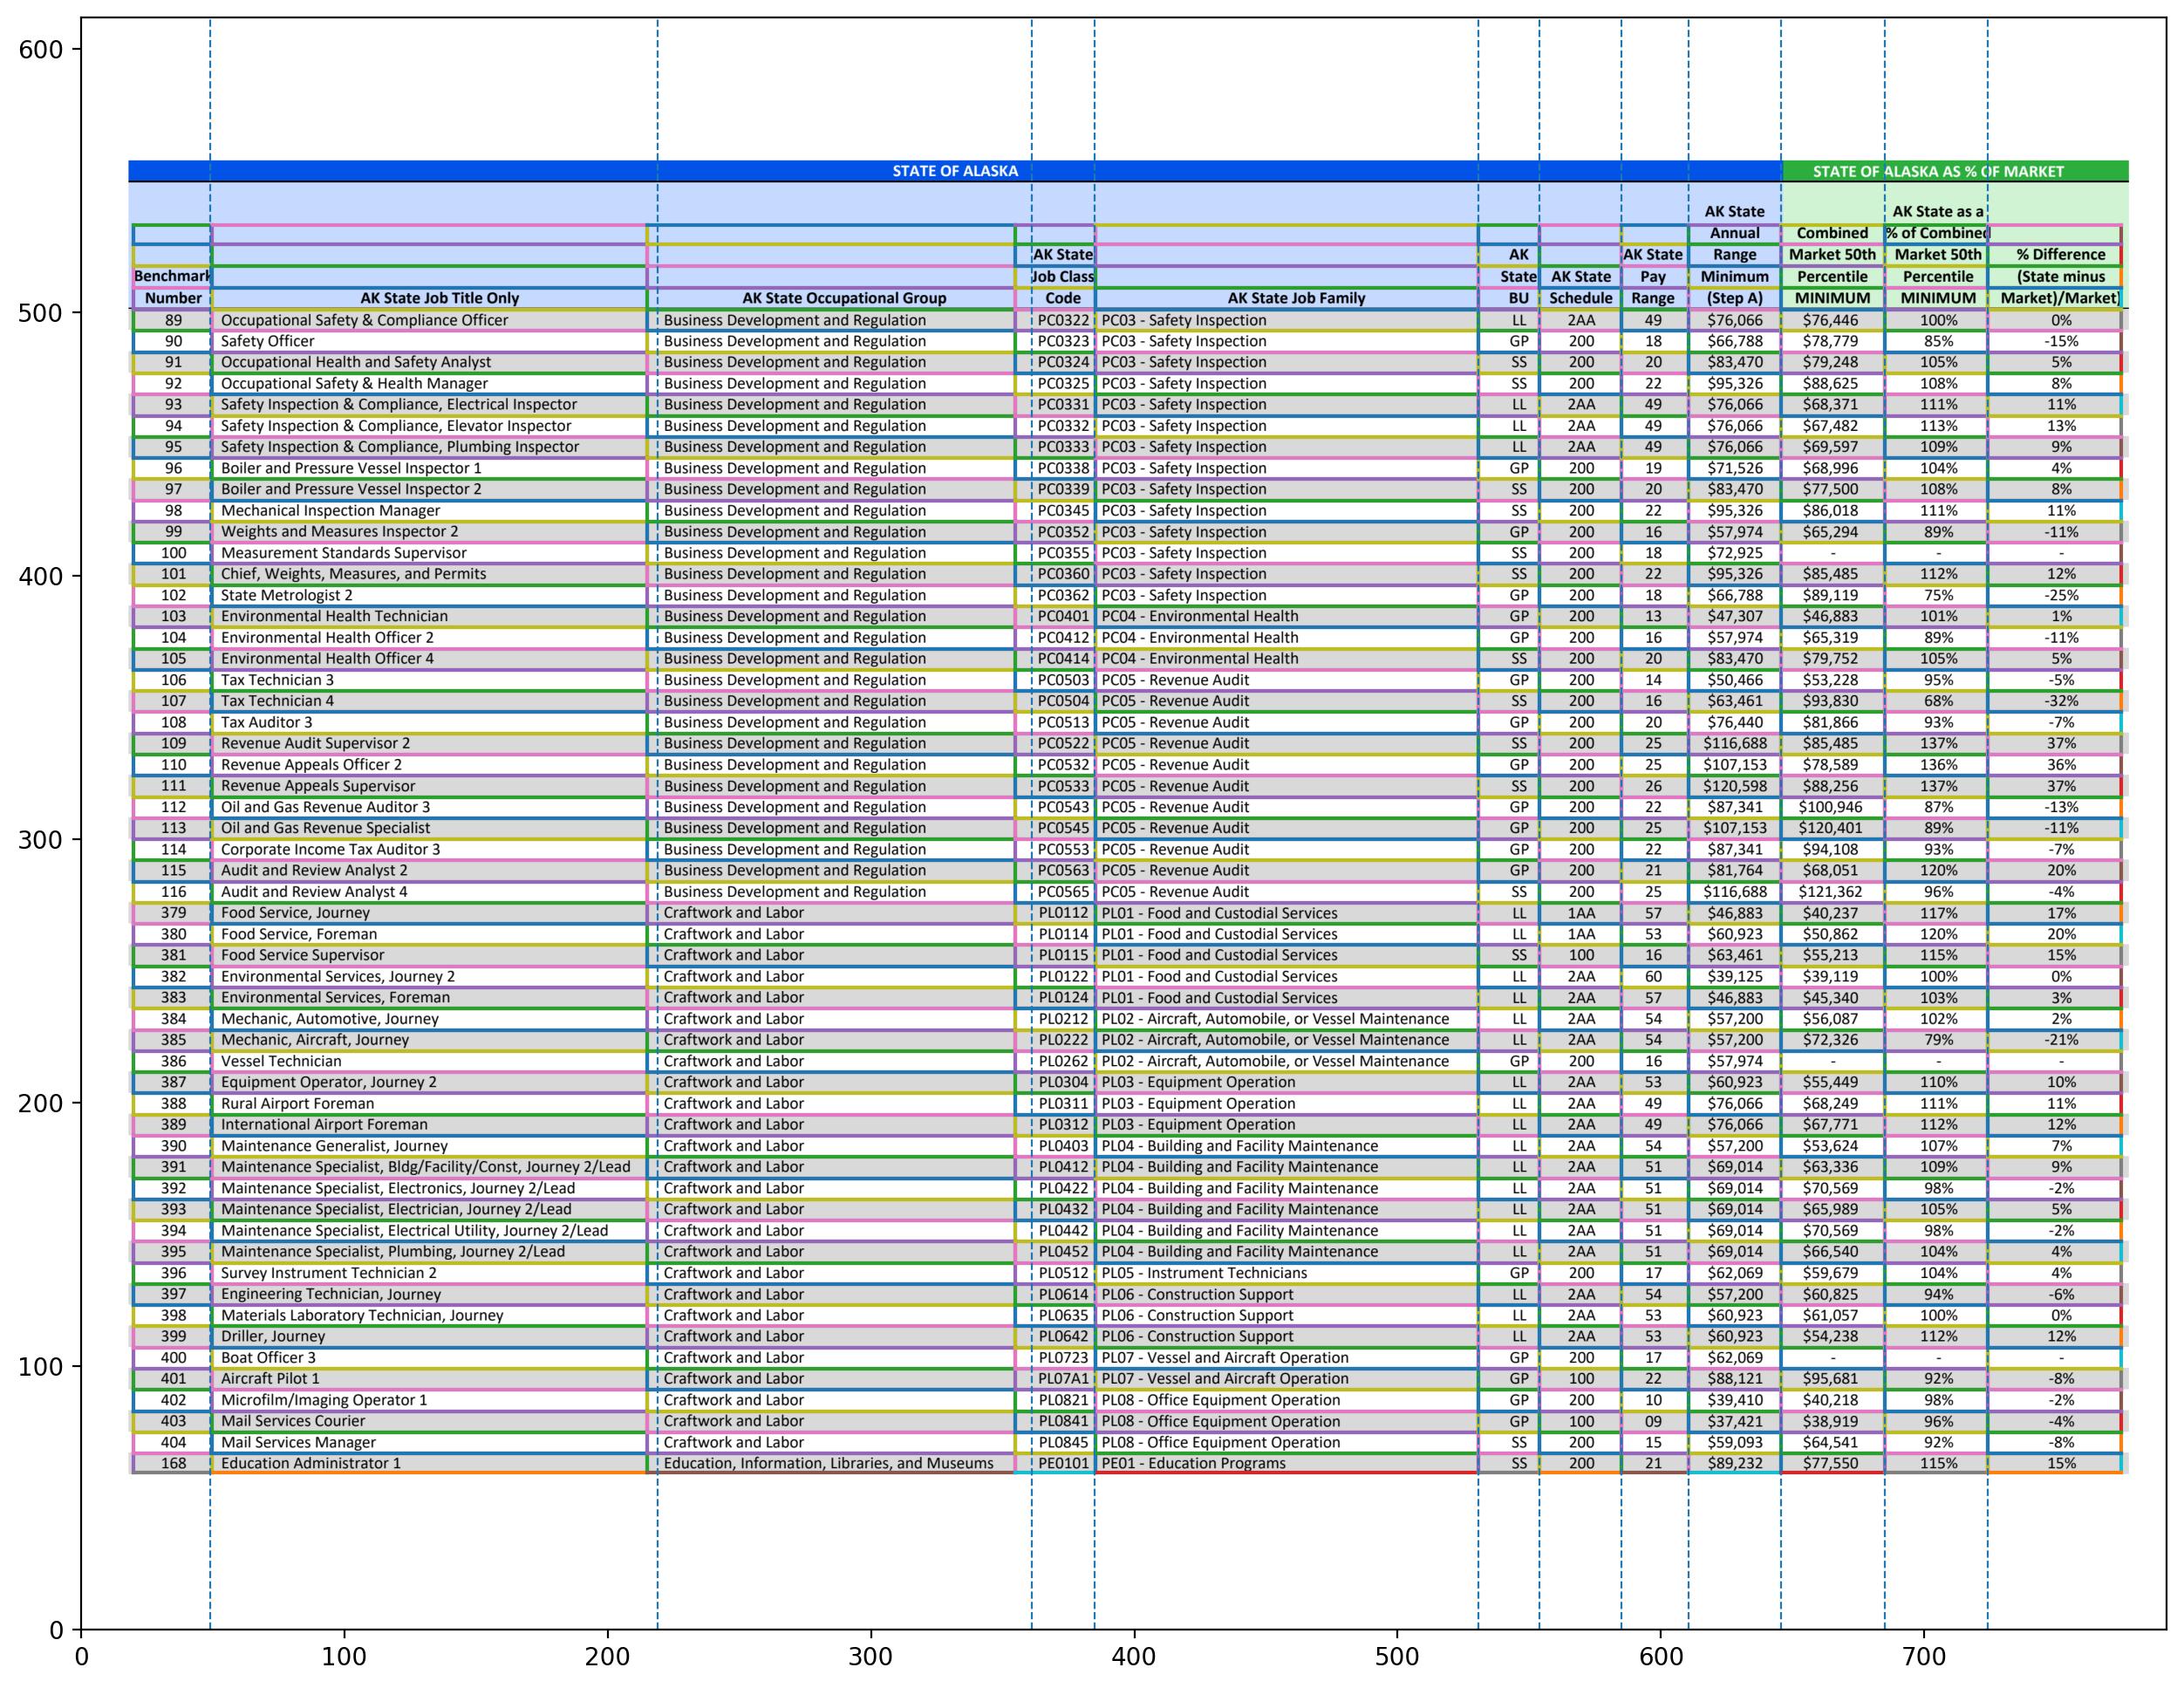

Detected 2 table region(s) on page 2.
Parsed shape: (59, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,Annual,Combined,% of Combined,
1,,,,AK State,,AK,,AK State,Range,Market 50th,Market 50th,% Difference
2,Benchmark,,,Job Class,,State,AK State,Pay,Minimum,Percentile,Percentile,(State minus
3,Number,AK State Job Title Only,AK State Occupational Group,Code,AK State Job Family,BU,Schedule,Range,(Step A),MINIMUM,MINIMUM,Market)/Market)
4,89,Occupational Safety & Compliance Officer,Business Development and Regulation,PC0322,PC03 ‐ Safety Inspection,LL,2AA,49,"$76,066","$76,446",100%,0%
5,90,Safety Officer,Business Development and Regulation,PC0323,PC03 ‐ Safety Inspection,GP,200,18,"$66,788","$78,779",85%,‐15%
6,91,Occupational Health and Safety Analyst,Business Development and Regulation,PC0324,PC03 ‐ Safety Inspection,SS,200,20,"$83,470","$79,248",105%,5%
7,92,Occupational Safety & Health Manager,Business Development and Regulation,PC0325,PC03 ‐ Safety Inspection,SS,200,22,"$95,326","$88,625",108%,8%
8,93,"Safety Inspection & Compliance, Electrical Ins...",Business Development and Regulation,PC0331,PC03 ‐ Safety Inspection,LL,2AA,49,"$76,066","$68,371",111%,11%
9,94,"Safety Inspection & Compliance, Elevator Inspe...",Business Development and Regulation,PC0332,PC03 ‐ Safety Inspection,LL,2AA,49,"$76,066","$67,482",113%,13%


In [47]:
import itertools
import camelot
import matplotlib.pyplot as plt

# 1. Define PDF path and read page 1 to inspect boundaries
pdf_path = "SegalData/Market50thPercentileMinimum.pdf"
tables = camelot.read_pdf(pdf_path, pages="3", flavor="stream", edge_tol=100)

# 2. Compute the unique right-edge x1 coordinates
cells = list(itertools.chain.from_iterable(tables[0].cells))
boundaries = sorted({cell.x1 for cell in cells})
print("Detected boundaries:", boundaries)

# 3. Build the single comma‑separated string of interior separators
#    (skip the very first/last if you want margins to act as edges)
interior = boundaries[1:-1]
col_string = ",".join(f"{x:.4f}" for x in boundaries)
print(col_string)
col_string = "49,219,361,385,530.7857,553.6813,585.0910,610.4947,645.4368,685.1028,724.1594"

## 4. (Optional) Visualize for confirmation
fig, ax = plt.subplots(figsize=(16, 12), dpi=200)
camelot.plot(tables[0], kind="grid", ax=ax)
separators = [float(x) for x in col_string.split(",")]
for x in separators:
    ax.axvline(x, linestyle="--", linewidth=0.8)
plt.show()

# 5. Re‑parse with the *one* columns string
preview = camelot.read_pdf(
    pdf_path,
    pages="3",               # must be "2", not "0"  [oai_citation_attribution:3‡Camelot](https://camelot-py.readthedocs.io/en/master/user/quickstart.html?utm_source=chatgpt.com)
    flavor="stream",
    edge_tol=100
)
n = len(preview)             # number of bboxes detected  [oai_citation_attribution:4‡GitHub](https://github.com/atlanhq/camelot/issues/357?utm_source=chatgpt.com)
print(f"Detected {n} table region(s) on page 2.")

# 5a Build a columns list that repeats your string n times
cols = [col_string] * n      # GH issue #357 workaround  [oai_citation_attribution:5‡GitHub](https://github.com/atlanhq/camelot/issues/357?utm_source=chatgpt.com)

# 5b Re‑parse page 2 with the exact matching columns list
tables = camelot.read_pdf(
    pdf_path,
    pages="3",
    flavor="stream",
    edge_tol=100,
    columns=cols,            # one entry per detected table region
    split_text=True,
    strip_text="\n"
)

# 6 Extract and inspect the DataFrame
df = tables[0].df.copy()
print("Parsed shape:", df.shape)
df.head(15)

In [12]:
import camelot
import pandas as pd

#pdf_path = "SegalData/Market65thPercentileMidpoint.pdf"

# Your tuned separator string
#col_string = "66.75,241,376.5,404.25,555,575.5708,602.7260,624.5394,659.5076,696.1908,727.7016"

# We'll need the page list from Camelot itself
from camelot.handlers import PDFHandler
handler    = PDFHandler(filepath=pdf_path, pages="1-end")
pages      = handler.pages             # e.g. [1,2,...,8]  [oai_citation_attribution:3‡Camelot](https://camelot-py.readthedocs.io/en/master/_modules/camelot/io.html?utm_source=chatgpt.com)

dfs = []
for pg in pages:
    # 1) Quick detect (no columns) to see how many bboxes/tables
    preview = camelot.read_pdf(
        pdf_path,
        pages=str(pg),
        flavor="stream",
        edge_tol=100,
    )
    n = len(preview)                   # number of bboxes Camelot found 

    # 2) Build a columns list that repeats your string n times
    cols = [col_string] * n            # workaround from GH issue #357  [oai_citation_attribution:4‡GitHub](https://github.com/atlanhq/camelot/issues/357?utm_source=chatgpt.com)

    # 3) Re‑parse with the exact matching columns list
    tables = camelot.read_pdf(
        pdf_path,
        pages=str(pg),
        flavor="stream",
        edge_tol=100,
        columns=cols,
        split_text=True,
        strip_text="\n",
    )

    # 4) Take the first table (or merge them as needed)
    if tables:
        df_page = tables[0].df.copy()
        dfs.append(df_page)

# 5) Stitch all pages together
combined = pd.concat(dfs, ignore_index=True)
print("Combined shape:", combined.shape)
combined.head()

ZeroDivisionError: float division by zero

In [13]:
import pandas as pd



# 6) Rename your columns
#combined.columns = [
#    "benchmark", "title", "group", "code", "family",
#    "BU", "schedule", "range", "step",
#    "ak_annual_salary", "market_target_annual_salary"
#]

# 7) Confirm
print("Combined shape:", combined.shape)
combined.head(10)

Combined shape: (455, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,AK State as,
1,,,,,,,,,,,a % of,
2,,,,AK,,,,,AK State,Combined,Combined,
3,,,,State,,,,AK,Annual,Market,Market,% Difference
4,,,,Job,,AK,,State,Range,65th,65th,(State minus
5,Benchmark,,,Class,,State,AK State,Pay,Minimum,Percentile,Percentile,Market)/
6,Number,AK State Job Title Only,AK State Occupational Group,Code,AK State Job Family,BU,Schedule,Range,(Step A),MINIMUM,MINIMUM,Market)
7,3,Office Assistant 1,Administrative and Office Support,PB0102,PB01 ‐ General Administration,GP,200,08,"$34,983","$43,186",81%,‐19%
8,4,Secretary,Administrative and Office Support,PB0130,PB01 ‐ General Administration,XE,N00,11,"$43,115","$56,890",76%,‐24%
9,5,Executive Secretary 3,Administrative and Office Support,PB0137,PB01 ‐ General Administration,XE,N00,16,"$59,534","$73,930",81%,‐19%


In [26]:
import os

# 1. Determine step letter from filename
fname = os.path.basename(pdf_path)
if "minimum"   in fname.lower(): step_val = "A"
elif "midpoint" in fname.lower(): step_val = "F"
elif "maximum"  in fname.lower(): step_val = "O"
else:                             step_val = ""

# 2. Insert the step column after the “range” (position 8)
combined.insert(8, "step", step_val)

# 3. Drop the old percent‐of‐market and adjustment columns (original cols 10 & 11 → now at positions 11 & 12)
combined = combined.drop(columns=[combined.columns[11], combined.columns[12]])

combined.head(10)

# 4. Rename remaining columns by index → meaningful names
combined = combined.rename(columns={
    0: "benchmark",
    1: "title",
    2: "group",
    3: "code",
    4: "family",
    5: "BU",
    6: "schedule",
    7: "range",
    8: "ak_annual_salary",
    9:"market_target_annual_salary"
})

# 5. Keep only rows where “benchmark” is a pure integer
combined = combined[combined["benchmark"].astype(str).str.match(r'^[0-9]+$')].reset_index(drop=True)

# 6. Convert Salary strings to float
combined[["ak_annual_salary","market_target_annual_salary"]] = (
    combined[["ak_annual_salary","market_target_annual_salary"]]
    # strip $, commas, and standalone dashes
    .replace({r"[\$,]": "", r"^-?$": ""}, regex=True)
    # convert to numeric, coercing invalids (like the empty strings) to NaN
    .apply(pd.to_numeric, errors="coerce")
)

# 7. Strip extra spaces
# Identify all string/object‑dtype columns
string_cols = combined.select_dtypes(include=['object']).columns

# Strip leading/trailing whitespace from each
combined[string_cols] = combined[string_cols].apply(lambda col: col.str.strip())

combined.head(10)

,benchmark,title,group,code,family,BU,schedule,range,step,ak_annual_salary,market_target_annual_salary
0,3,Office Assistant 1,Administrative and Office Support,PB0102,PB01 ‐ General Administration,GP,200,08,A,34983,43186.0
1,4,Secretary,Administrative and Office Support,PB0130,PB01 ‐ General Administration,XE,N00,11,A,43115,56890.0
2,5,Executive Secretary 3,Administrative and Office Support,PB0137,PB01 ‐ General Administration,XE,N00,16,A,59534,73930.0
3,6,Administrative Assistant 2,Administrative and Office Support,PB0152,PB01 ‐ General Administration,GP,200,14,A,50466,48093.0
4,7,Administrative Officer 1,Administrative and Office Support,PB0154,PB01 ‐ General Administration,SS,200,17,A,67995,66080.0
5,8,Administrative Operations Manager 1,Administrative and Office Support,PB0157,PB01 ‐ General Administration,SS,200,22,A,95326,81088.0
6,9,Accounting Clerk,Administrative and Office Support,PB0202,PB02 ‐ Accounting and Fiscal,GP,200,10,A,39410,43463.0
7,10,Accounting Technician 2,Administrative and Office Support,PB0206,PB02 ‐ Accounting and Fiscal,GP,200,14,A,50466,54912.0
8,11,Accountant 2,Administrative and Office Support,PB0212,PB02 ‐ Accounting and Fiscal,GP,200,16,A,57974,72003.0
9,12,Accountant 4,Administrative and Office Support,PB0214,PB02 ‐ Accounting and Fiscal,SS,200,20,A,83470,80664.0


In [29]:
validate_df(combined)

❌ 20 row(s) failed validation:

 • Row 30: failed column(s): market_target_annual_salary
 • Row 31: failed column(s): market_target_annual_salary
 • Row 67: failed column(s): market_target_annual_salary
 • Row 75: failed column(s): market_target_annual_salary
 • Row 77: failed column(s): market_target_annual_salary
 • Row 78: failed column(s): market_target_annual_salary
 • Row 119: failed column(s): market_target_annual_salary
 • Row 143: failed column(s): market_target_annual_salary
 • Row 157: failed column(s): market_target_annual_salary
 • Row 195: failed column(s): market_target_annual_salary
 • Row 224: failed column(s): market_target_annual_salary
 • Row 229: failed column(s): market_target_annual_salary
 • Row 230: failed column(s): market_target_annual_salary
 • Row 233: failed column(s): market_target_annual_salary
 • Row 263: failed column(s): market_target_annual_salary
 • Row 266: failed column(s): market_target_annual_salary
 • Row 329: failed column(s): market_target_an

In [ ]:
import os
import itertools
import camelot
import pandas as pd
from camelot.handlers import PDFHandler

# --- Configuration ---
input_dir  = "SegalData"
output_dir = os.path.join(input_dir, "processed")
os.makedirs(output_dir, exist_ok=True)

# Your manually‑tuned interior separators
col_string = "66.75,241,376.5,404.25,555,575.5708,602.7260,624.5394,659.5076,696.1908,727.7016"

all_dfs = []

# --- Process each PDF in SegalData ---
for fname in os.listdir(input_dir):
    if not fname.lower().endswith(".pdf"):
        continue

    pdf_path = os.path.join(input_dir, fname)

    # 1) Ask Camelot how many pages it will parse
    handler = PDFHandler(filepath=pdf_path, pages="1-end")
    pages   = handler.pages  # e.g. [1,2,...,N]

    dfs = []
    for pg in pages:
        # 2) Preview page to count table‐regions
        preview = camelot.read_pdf(pdf_path, pages=str(pg),
                                   flavor="stream", edge_tol=100)
        n = len(preview)
        if n < 1:
            continue

        # 3) Build a columns list (one entry per region)
        cols = [col_string] * n

        # 4) Re‑parse page with your exact separators
        tables = camelot.read_pdf(
            pdf_path,
            pages=str(pg),
            flavor="stream",
            edge_tol=100,
            columns=cols,
            split_text=True,
            strip_text="\n",
        )
        if tables:
            dfs.append(tables[0].df.copy())

    if not dfs:
        continue

    # 5) Stitch the pages together
    df = pd.concat(dfs, ignore_index=True)

    # 6) Derive 'step' from filename
    base = os.path.splitext(fname)[0].lower()
    if "minimum"   in base:
        step_val = "A"
    elif "midpoint" in base:
        step_val = "F"
    elif "maximum"  in base:
        step_val = "O"
    else:
        step_val = ""
    df.insert(8, "step", step_val)

    # 7) Drop the old percent‑of‑market & adjustment columns
    df.drop(columns=df.columns[-2:], inplace=True)

    # 8) Rename columns
    df.rename(columns={
        0: "benchmark",
        1: "title",
        2: "group",
        3: "code",
        4: "family",
        5: "BU",
        6: "schedule",
        7: "range",
        8: "ak_annual_salary",
        9:"market_target_annual_salary"
        }, inplace=True)

    # 9) Keep only rows with integer benchmarks
    df = df[df["benchmark"].astype(str).str.match(r'^[0-9]+$')].reset_index(drop=True)

    # 10) Clean salary columns into floats, coerce "-" to NaN
    df[["ak_annual_salary","market_target_annual_salary"]] = (
        df[["ak_annual_salary","market_target_annual_salary"]]
        .replace({r"[\$,]": "", r"^-?$": ""}, regex=True)
        .apply(pd.to_numeric, errors="coerce")
    )

    # 11) Strip whitespace on all text columns
    str_cols = df.select_dtypes(include=["object"]).columns
    df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

    # 12) Save per‑PDF outputs
    out_base = os.path.join(output_dir, base)
    df.to_csv(f"{out_base}.csv", index=False)
    df.to_parquet(f"{out_base}.parquet", index=False)

    all_dfs.append(df)

# --- Combine all into a master file ---
if all_dfs:
    full = pd.concat(all_dfs, ignore_index=True)
    full.to_csv(os.path.join(input_dir, "all_salaries.csv"), index=False)
    full.to_parquet(os.path.join(input_dir, "all_salaries.parquet"), index=False)

print("Done! Processed", len(all_dfs), "PDFs.")

KeyError: "['market_target_annual_salary'] not in index"

In [48]:
import os
import camelot
import pandas as pd
from camelot.handlers import PDFHandler

# --- Configuration ---
input_dir  = "SegalData"
output_dir = os.path.join(input_dir, "processed")
os.makedirs(output_dir, exist_ok=True)

# tuned separators per file
column_map = {
    "market65thpercentileminimum":
        "66.75,241,376.5,404.25,555,575.5708,602.7260,624.5394,659.5076,696.1908,727.7016",
    "market50thpercentilemidpoint":
        "59.2917,220.3201,366.5508,407.1267,560.8244,581.2313,613.2912,636.9617,668.0224,702.0068,737.5867",
    "market50thpercentilemaximum":
        "60.0975,217.7251,366.3102,399,541.9117,571.9918,599.1387,621.0759,656.6869,694.7775,727.8474",
    "market65thpercentilemaximum":
        "59,230,375,401,558,578.6675,606.5189,628.9734,665.2012,703.2194,734.7334",
    "market65thpercentilemidpoint":
        "59,235,380,404,558,581.6066,609.4596,631.3482,665.7069,701.7793,733.4437",
    "market50thpercentileminimum":
        "49,219,361,385,530.7857,553.6813,585.0910,610.4947,645.4368,685.1028,724.1594"
    # add others as you discover them...
}

# fallback if a file isn’t yet in column_map
default_cols = column_map["market65thpercentileminimum"]

def clean_col_string(raw: str) -> str:
    """
    Remove duplicates and sort ascending, to avoid zero-width columns.
    """
    nums = sorted({float(x) for x in raw.split(",")})
    # reformat with no trailing .0 if possible
    return ",".join(str(int(x)) if x.is_integer() else str(x) for x in nums)

all_dfs = []

for fname in os.listdir(input_dir):
    if not fname.lower().endswith(".pdf"):
        continue

    base = os.path.splitext(fname)[0].lower()
    pdf_path = os.path.join(input_dir, fname)

    # pick & clean the column string
    raw_cols = column_map.get(base, default_cols)
    col_string = clean_col_string(raw_cols)

    # get pages
    pages = PDFHandler(filepath=pdf_path, pages="1-end").pages

    dfs = []
    for pg in pages:
        preview = camelot.read_pdf(
            pdf_path, pages=str(pg), flavor="stream", edge_tol=100
        )
        n = len(preview)
        if n < 1:
            continue

        cols = [col_string] * n
        try:
            # try the manual split first
            tables = camelot.read_pdf(
                pdf_path,
                pages=str(pg),
                flavor="stream",
                edge_tol=100,
                columns=cols,
                split_text=True,
                strip_text="\n",
            )
        except ZeroDivisionError:
            # on failure, fall back to auto‑detect
            tables = camelot.read_pdf(
                pdf_path,
                pages=str(pg),
                flavor="stream",
                edge_tol=100,
                split_text=True,
                strip_text="\n",
            )

        if tables:
            dfs.append(tables[0].df.copy())

    if not dfs:
        continue

    df = pd.concat(dfs, ignore_index=True)

    # derive 'step'
    if "minimum"   in base:
        step_val = "A"
    elif "midpoint" in base:
        step_val = "F"
    elif "maximum"  in base:
        step_val = "O"
    else:
        step_val = ""
    df.insert(8, "step", step_val)

    # derive 'percentile'
    if "50" in base:
        pct = 50
    elif "65" in base:
        pct = 65
    else:
        pct = None
    df["percentile"] = pct

    # drop, rename, filter, clean salaries, strip whitespace…
    df.drop(columns=df.columns[-3:], inplace=True)
    df.rename(columns={
        0: "benchmark", 1: "title", 2: "group", 3: "code",
        4: "family", 5: "BU", 6: "schedule", 7: "range",
        8: "ak_annual_salary", 9: "market_target_annual_salary"
    }, inplace=True)
    df = df[df["benchmark"].astype(str).str.match(r'^[0-9]+$')].reset_index(drop=True)
    df[["ak_annual_salary","market_target_annual_salary"]] = (
        df[["ak_annual_salary","market_target_annual_salary"]]
        .replace({r"[\$,]": "", r"^-?$": ""}, regex=True)
        .apply(pd.to_numeric, errors="coerce")
    )
    str_cols = df.select_dtypes(include=["object"]).columns
    df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

    df.insert(11, "percentile", pct)

    # after df = pd.concat(dfs, ignore_index=True)

    # fix those (cid:xxx) artifacts in *all* text columns
    cid_map = {
        r"\(cid:415\)": "ti",
        r"\(cid:332\)": "ft",
        # if you find more codes, just add them here
    }

    # apply replacements across all object‑dtype cols
    text_cols = df.select_dtypes(include=["object"]).columns
    for pattern, replacement in cid_map.items():
        df[text_cols] = df[text_cols].replace(pattern, replacement, regex=True)

    # save
    out_base = os.path.join(output_dir, base)
    df.to_csv(f"{out_base}.csv", index=False)
    df.to_parquet(f"{out_base}.parquet", index=False)

    all_dfs.append(df)

# master file
if all_dfs:
    full = pd.concat(all_dfs, ignore_index=True)
    full.to_csv(os.path.join(input_dir, "all_salaries.csv"), index=False)
    full.to_parquet(os.path.join(input_dir, "all_salaries.parquet"), index=False)

print("Done! Processed", len(all_dfs), "PDFs.")

Done! Processed 6 PDFs.


In [23]:
full.head(20)

,benchmark,title,group,code,family,BU,schedule,range,step,ak_annual_salary,market_target_annual_salary,percentile
0,3,Office Assistant 1,Administrative and Office Support,PB0102,PB01 ‐ General Administration,GP,200,08,F,40560,45935.0,50
1,4,Secretary,Administrative and Office Support,PB0130,PB01 ‐ General Administration,XE,N00,11,F,50193,60583.0,50
2,5,Executive Secretary 3,Administrative and Office Support,PB0137,PB01 ‐ General Administration,XE,N00,16,F,70980,83553.0,50
3,6,Administrative Assistant 2,Administrative and Office Support,PB0152,PB01 ‐ General Administration,GP,200,14,F,60138,55439.0,50
4,7,Administrative Officer 1,Administrative and Office Support,PB0154,PB01 ‐ General Administration,SS,200,17,F,78000,73816.0,50
5,8,Administrative Operations Manager 1,Administrative and Office Support,PB0157,PB01 ‐ General Administration,SS,200,22,F,108867,92939.0,50
6,9,Accounting Clerk,Administrative and Office Support,PB0202,PB02 ‐ Accounting and Fiscal,GP,200,10,F,45786,48626.0,50
7,10,Accounting Technician 2,Administrative and Office Support,PB0206,PB02 ‐ Accounting and Fiscal,GP,200,14,F,60138,56970.0,50
8,11,Accountant 2,Administrative and Office Support,PB0212,PB02 ‐ Accounting and Fiscal,GP,200,16,F,69147,80779.0,50
9,12,Accountant 4,Administrative and Office Support,PB0214,PB02 ‐ Accounting and Fiscal,SS,200,20,F,95326,95855.0,50


In [50]:
# 1. Select the columns you need and drop duplicates
salary_schedule = (
    full[['BU', 'schedule', 'range', 'step', 'ak_annual_salary']]
    .drop_duplicates()
)

# 2. Sort ascending by BU, schedule, range, then step
salary_schedule = salary_schedule.sort_values(
    ['BU', 'schedule', 'step', 'range'],
    ignore_index=True
)

# 3. Write out to CSV and Parquet
salary_schedule.to_csv('salary_schedule.csv', index=False)
salary_schedule.to_parquet('salary_schedule.parquet', index=False)

In [52]:
import pandas as pd
import numpy as np

# 1. Copy only the 65th‐percentile rows
df65 = full[full['percentile'] == 65].copy()

# 2. Build the lookup table (using only those rows)
lookup = (
    df65[['BU','schedule','range','step','ak_annual_salary']]
      .drop_duplicates()
      .reset_index(drop=True)
)

# 3. Define the “nearest‐range” function exactly as before
def find_nearest_range(row):
    mkt = row.market_target_annual_salary
    if pd.isna(mkt):
        return np.nan
    mask = (
        (lookup.BU        == row.BU)       &
        (lookup.schedule == row.schedule) &
        (lookup.step     == row.step)
    )
    sub = lookup[mask]
    if sub.empty:
        return np.nan
    diffs = (sub.ak_annual_salary - mkt).abs().values
    pos   = diffs.argmin()
    return sub.iloc[pos]['range']

# 4. Apply to this filtered DataFrame
df65['Nearest_Step'] = df65.apply(find_nearest_range, axis=1)

# 5. Export just the 65th‐percentile slice
df65.to_csv('full_p65_with_nearest.csv', index=False)
df65.to_parquet('full_p65_with_nearest.parquet', index=False)

In [49]:
# 1. Compute group‐sizes
group_counts = (
    full
    .groupby(['percentile','step'])
    .size()
    .reset_index(name='count')
)

# 2. Sort ascending so the lowest‐counts bubble to the top
group_counts = group_counts.sort_values('count', ignore_index=True)

# 3. Inspect the bottom handful
print(group_counts.head(10))

   percentile step  count
0          50    A    404
1          50    F    404
2          50    O    404
3          65    A    404
4          65    F    404
5          65    O    404
